In [ ]:
!pip install autokeras

In [1]:
import tensorflow as tf
import autokeras as ak

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[-1], 'GPU')

### Load MNIST dataset

In [3]:
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print('Training image shape:', x_train.shape) # (60000, 28, 28)
print('Training label shape:', y_train.shape) # (60000,)
print('First five training labels:', y_train[:5]) # array([5 0 4 1 9], dtype=uint8)

Training image shape: (60000, 28, 28)
Training label shape: (60000,)
First five training labels: [5 0 4 1 9]


### Run the ImageClassifier

In [4]:
from kerastuner.engine import hyperparameters as hp


input_node = ak.ImageInput()
output_node = ak.Normalization()(input_node)
output_node = ak.ConvBlock(num_blocks=2,
                           max_pooling=True,
                           separable=False,
                           dropout=0.0)(output_node)
# kernel_size = hp.Choice("kernel_size", [3, 5, 7]),
#                            separable=False,
output_node = ak.ClassificationHead(dropout=0.0)(output_node)

auto_model = ak.AutoModel(
    inputs=input_node, 
    outputs=output_node,
    max_trials=10,
    overwrite=True,
    seed=42)

auto_model.fit(x_train, y_train, epochs=3) # ,epochs=3, verbose=2
test_loss, test_acc = auto_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy: ', test_acc)

Trial 10 Complete [00h 00m 40s]
val_loss: 0.028493061661720276

Best val_loss So Far: 0.028493061661720276
Total elapsed time: 00h 07m 22s
INFO:tensorflow:Oracle triggered exit
Epoch 1/3
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2010 - accuracy: 0.9387
Epoch 2/3
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0389 - accuracy: 0.9884
Epoch 3/3
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0151 - accuracy: 0.9957
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./auto_model/best_model/assets


### Get the summarized results during the tuning process (return the best 10 models if existed)

In [5]:
auto_model.tuner.results_summary(1)

Results summary
Results in ./auto_model
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
conv_block_1/kernel_size: 5
conv_block_1/num_layers: 2
conv_block_1/filters_0_0: 128
conv_block_1/filters_0_1: 16
conv_block_1/filters_1_0: 16
conv_block_1/filters_1_1: 512
classification_head_1/spatial_reduction_1/reduction_type: flatten
optimizer: adam_weight_decay
learning_rate: 0.001
Score: 0.028493061661720276


### Retrieve & Display best model

In [6]:
best_model = auto_model.export_model()
best_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
cast_to_float32 (CastToFloat (None, 28, 28)            0         
_________________________________________________________________
expand_last_dim (ExpandLastD (None, 28, 28, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 28, 28, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 24, 24, 128)       3328      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 16)        51216     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 5, 5, 16)         

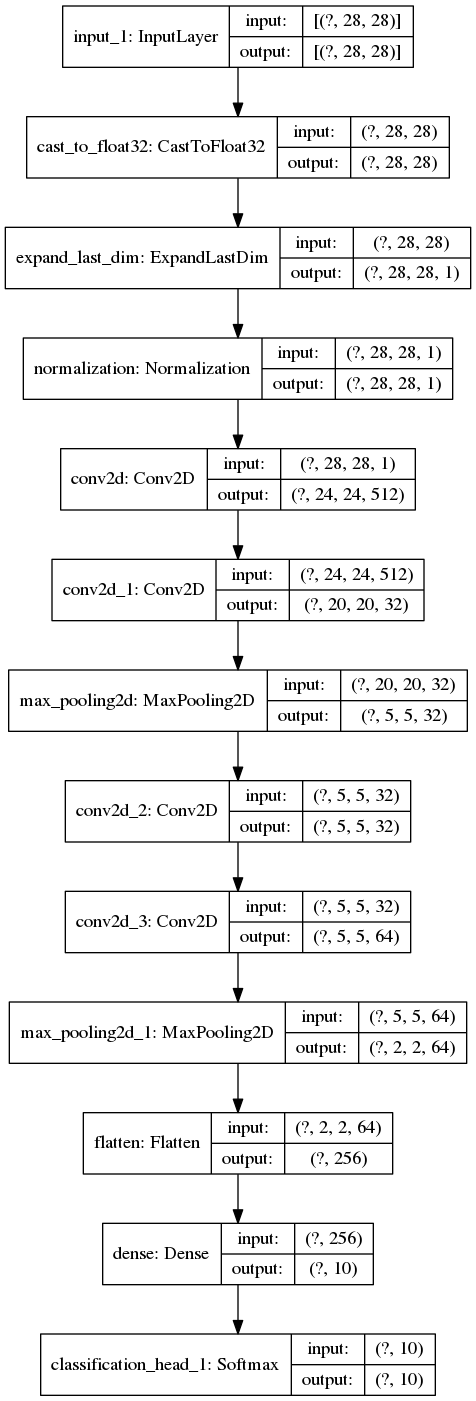

In [13]:
tf.keras.utils.plot_model(best_model, show_shapes=True, expand_nested=True)


### Predict with the best model.


In [14]:
predicted_y = auto_model.predict(x_test)
print(predicted_y)

[['7']
 ['2']
 ['1']
 ...
 ['4']
 ['5']
 ['6']]
